In [1]:
!pip install iterative-stratification fastai albumentations timm seaborn

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import tensorflow as tf
from fastai.vision.all import *
from fastai.callback.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import gc
import albumentations
import warnings
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import timm
import shutil
from sklearn.utils.class_weight import compute_class_weight

2025-03-01 23:07:38.029130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740845258.602463 3188328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740845258.833722 3188328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 23:07:40.549192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/projekj/miniconda3/envs/punenv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version o

In [3]:
config = {
    'seed': 3407,
    'use_cuda': True,
    'image_size': 224,
    'batch_size': 64,
    'num_workers': 4,
    'num_folds': 5,
    'model_resnet_a1': 'timm/resnet50.a1_in1k',
    'model_resnet_tv2': 'timm/resnet50.tv2_in1k',
    'mixed_precision' : True,
    'augmentation_type': 'cutmix',  # or 'cutmix','cutout',None
    'fit_one_cycle_epochs': 20,
    'learning_rate': 1e-4,
    'train_csv_path': '/home/projekj/Deep learning/data/train/train_data.csv',
    'test_csv_path': '/home/projekj/Deep learning/data/test/test_data.csv',
    'train_image_path' : None,
    'test_image_path' : None,
    'output_csv_path': None,
    'output_csv_confidence_path': None, # For Pesudo Label
    'num_gpus': torch.cuda.device_count()  # Use all available GPUs
}

In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(config['seed'], config['use_cuda'])

In [5]:
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

dataset = '/home/projekj/Deep learning/dataset/dataset'

for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    if os.path.isdir(folder_path):
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Split the data into training and testing sets (80% train, 20% test)
train_daf, test_daf = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_csv_file_path = '/home/projekj/Deep learning/data/train/train_data.csv'
test_csv_file_path = '/home/projekj/Deep learning/data/test/test_data.csv'


train_daf.to_csv(train_csv_file_path, index=False)
test_daf.to_csv(test_csv_file_path, index=False)

print(f'Training DataFrame saved to {train_csv_file_path}')
print(f'Test DataFrame saved to {test_csv_file_path}')


Training DataFrame saved to /home/projekj/Deep learning/data/train/train_data.csv
Test DataFrame saved to /home/projekj/Deep learning/data/test/test_data.csv


In [6]:
train_df = pd.read_csv(config['train_csv_path'])
train_df['image_path'] = train_df['image_path'].apply(lambda x : x)
train_df

,image_path,label
0,/home/projekj/Deep learning/dataset/dataset/cloudy/cloudy0_104.jpg,cloudy
1,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise0_172.jpg,sunrise
2,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_0_138.jpg,foggy
3,/home/projekj/Deep learning/dataset/dataset/shine/shine_re_1_153.jpg,shine
4,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_113.jpg,sunrise
...,...,...
2947,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_1_5.jpg,foggy
2948,/home/projekj/Deep learning/dataset/dataset/cloudy/cloudy1_207.jpg,cloudy
2949,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise126.jpg,sunrise
2950,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_412.jpg,sunrise


<Axes: xlabel='label'>

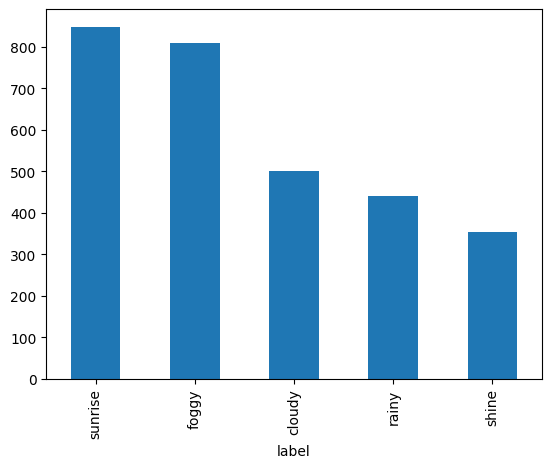

In [7]:
train_df.label.value_counts().plot.bar()

In [8]:
strat_kfold = MultilabelStratifiedKFold(n_splits=config['num_folds'], random_state=config['seed'], shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_path.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df.head()

,image_path,label,fold
0,/home/projekj/Deep learning/dataset/dataset/cloudy/cloudy0_104.jpg,cloudy,2
1,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise0_172.jpg,sunrise,4
2,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_0_138.jpg,foggy,3
3,/home/projekj/Deep learning/dataset/dataset/shine/shine_re_1_153.jpg,shine,1
4,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_113.jpg,sunrise,4


<Axes: xlabel='fold'>

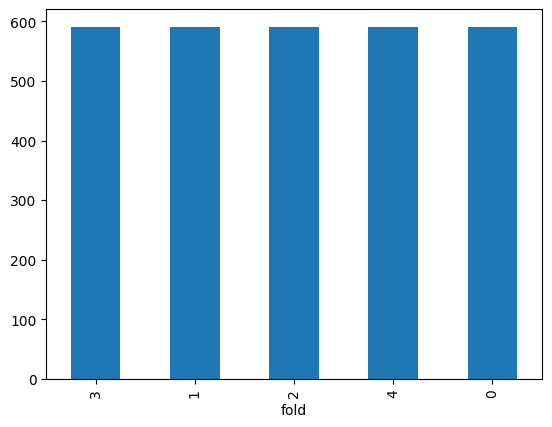

In [9]:
train_df.fold.value_counts().plot.bar()

In [10]:
class_labels = train_df['label'].values
classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define custom loss function with class weights
def weighted_loss(pred, target):
    weights_tensor = torch.tensor([class_weights_dict[cls] for cls in dls.vocab]).float().to('cuda')
    return F.cross_entropy(pred, target, weight=weights_tensor)

# Data Augmentation

In [11]:
class AlbumentationsTransform(RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): 
        super().__init__()
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
            
        aug_img = aug_img.astype(np.uint8)
        return PILImage.create(aug_img)

In [12]:
warnings.filterwarnings('ignore')

size = config['image_size']
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            albumentations.Rotate(limit=(-20, 20)),], p=1.0)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0)], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [13]:
def get_data(fold=0):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(0),
        get_y=ColReader(1),
        splitter=IndexSplitter(train_df[train_df.fold == fold].index),
        item_tfms=[AlbumentationsTransform(get_train_aug(), get_train_aug())],
        batch_tfms=[Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(train_df, bs=config['batch_size'], num_workers=config['num_workers'])

In [14]:
test_df = pd.read_csv(config['test_csv_path'])
test_df['image_path'] = test_df['image_path'].apply(lambda x : x )
tstpng = test_df.copy()
tstpng.head()

,image_path,label
0,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise45.jpg,sunrise
1,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_337.jpg,sunrise
2,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise0_25.jpg,sunrise
3,/home/projekj/Deep learning/dataset/dataset/shine/shine43.jpg,shine
4,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_0_187.jpg,foggy


In [15]:
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    if config['num_gpus'] > 1:
        model = nn.DataParallel(model)
    return model

In [16]:
def get_augmentation_callback(augmentation_type, alpha=1.0, cutout_size=8):
    if augmentation_type == 'mixup':
        return MixUp(alpha=alpha)
    elif augmentation_type == 'cutmix':
        return CutMix(alpha=alpha)
    elif augmentation_type == 'cutout':
        # Return a callback that applies CutOut
        return aug_transforms(cutout=cutout_size)
    else:
        return None

# Training Resnet50.a1_in1k Model

In [ ]:
all_a1_preds = []
best_model_a1_path = "/home/projekj/Deep learning/best_model/best_model_resnet_a1.pth"

for i in range(config['num_folds']):
    dls = get_data(i)

    model = create_model(config['model_resnet_a1'], num_classes=len(dls.vocab))
    augmentation_callback = get_augmentation_callback(config['augmentation_type'])
    learn = Learner(dls, model,
                    loss_func=weighted_loss,  # Use the custom loss function
                    metrics=accuracy,
                    cbs=[SaveModelCallback(monitor='valid_loss')])

    if config['mixed_precision']:
        learn = learn.to_fp16()

    # Move model to GPU(s)
    learn.model = learn.model.to('cuda')

    # Clear cache before training
    torch.cuda.empty_cache()
    
#     learn.fine_tune(config['fine_tune_epochs'])
    learn.fit_one_cycle(config['fit_one_cycle_epochs'], lr_max=config['learning_rate'])
#     learn.fit_one_cycle(config['fit_one_cycle_epochs'])
    learn.dls = get_data(i)
#     learn.fine_tune(config['fit_one_cycle_epochs'], cbs=EarlyStoppingCallback(monitor='valid_loss'))
    
    # Clear cache after training
    torch.cuda.empty_cache()

    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_a1_preds.append(preds)
    torch.save(learn.model.state_dict(), best_model_a1_path)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,1.611919,1.607882,0.244068,00:04
1,1.601733,1.588163,0.389830,00:04
2,1.577904,1.543201,0.522034,00:04
3,1.526381,1.440335,0.652542,00:03
4,1.413020,1.217634,0.754237,00:04
5,1.217593,0.881132,0.837288,00:04
6,0.960508,0.602412,0.845763,00:04
7,0.748247,0.501643,0.845763,00:04
8,0.602842,0.457313,0.850847,00:04
9,0.504359,0.426797,0.849153,00:03


Better model found at epoch 0 with valid_loss value: 1.6078815460205078.
Better model found at epoch 1 with valid_loss value: 1.588163137435913.
Better model found at epoch 2 with valid_loss value: 1.5432008504867554.
Better model found at epoch 3 with valid_loss value: 1.4403351545333862.
Better model found at epoch 4 with valid_loss value: 1.217633605003357.
Better model found at epoch 5 with valid_loss value: 0.881132185459137.
Better model found at epoch 6 with valid_loss value: 0.6024124622344971.
Better model found at epoch 7 with valid_loss value: 0.501643180847168.
Better model found at epoch 8 with valid_loss value: 0.45731258392333984.
Better model found at epoch 9 with valid_loss value: 0.42679736018180847.
Better model found at epoch 10 with valid_loss value: 0.41229531168937683.
Better model found at epoch 11 with valid_loss value: 0.38938167691230774.
Better model found at epoch 12 with valid_loss value: 0.3855222165584564.
Better model found at epoch 13 with valid_loss v

epoch,train_loss,valid_loss,accuracy,time
0,1.608560,1.603061,0.235195,00:04
1,1.599092,1.579328,0.382403,00:04
2,1.573665,1.521824,0.658206,00:04
3,1.512732,1.389613,0.761421,00:04
4,1.376364,1.126918,0.796954,00:04
5,1.149685,0.815294,0.813875,00:04
6,0.903035,0.599441,0.835871,00:04
7,0.698760,0.515430,0.866328,00:04
8,0.553991,0.464635,0.878173,00:04
9,0.458490,0.439068,0.874789,00:04


Better model found at epoch 0 with valid_loss value: 1.6030611991882324.
Better model found at epoch 1 with valid_loss value: 1.579327940940857.
Better model found at epoch 2 with valid_loss value: 1.5218241214752197.
Better model found at epoch 3 with valid_loss value: 1.3896125555038452.
Better model found at epoch 4 with valid_loss value: 1.1269183158874512.
Better model found at epoch 5 with valid_loss value: 0.8152943253517151.
Better model found at epoch 6 with valid_loss value: 0.5994407534599304.
Better model found at epoch 7 with valid_loss value: 0.5154300928115845.
Better model found at epoch 8 with valid_loss value: 0.4646349847316742.
Better model found at epoch 9 with valid_loss value: 0.4390680193901062.
Better model found at epoch 10 with valid_loss value: 0.4268650710582733.
Better model found at epoch 11 with valid_loss value: 0.4102754294872284.
Better model found at epoch 12 with valid_loss value: 0.39863815903663635.
Better model found at epoch 13 with valid_loss v

epoch,train_loss,valid_loss,accuracy,time
0,1.599668,1.597615,0.269492,00:04
1,1.591003,1.576376,0.384746,00:04
2,1.565969,1.523187,0.608475,00:04
3,1.506210,1.397572,0.706780,00:04
4,1.371698,1.149694,0.776271,00:04
5,1.151499,0.841944,0.789831,00:04
6,0.904062,0.633770,0.822034,00:04
7,0.696929,0.548751,0.840678,00:04
8,0.563691,0.500658,0.837288,00:04
9,0.477171,0.472753,0.864407,00:04


Better model found at epoch 0 with valid_loss value: 1.597615361213684.
Better model found at epoch 1 with valid_loss value: 1.576375961303711.
Better model found at epoch 2 with valid_loss value: 1.5231866836547852.
Better model found at epoch 3 with valid_loss value: 1.3975719213485718.
Better model found at epoch 4 with valid_loss value: 1.1496938467025757.
Better model found at epoch 5 with valid_loss value: 0.8419439196586609.
Better model found at epoch 6 with valid_loss value: 0.633770227432251.
Better model found at epoch 7 with valid_loss value: 0.5487509369850159.
Better model found at epoch 8 with valid_loss value: 0.5006577968597412.
Better model found at epoch 9 with valid_loss value: 0.47275328636169434.
Better model found at epoch 10 with valid_loss value: 0.45051997900009155.
Better model found at epoch 11 with valid_loss value: 0.43213075399398804.
Better model found at epoch 12 with valid_loss value: 0.4194973409175873.
Better model found at epoch 13 with valid_loss v

epoch,train_loss,valid_loss,accuracy,time
0,1.601604,1.598893,0.275804,00:04
1,1.592579,1.576794,0.384095,00:04
2,1.568138,1.523652,0.605753,00:04
3,1.510457,1.394133,0.746193,00:04
4,1.368818,1.091062,0.795262,00:04
5,1.120917,0.731944,0.815567,00:04
6,0.872605,0.548484,0.818951,00:04
7,0.674302,0.463270,0.854484,00:04
8,0.546603,0.422793,0.871404,00:04
9,0.449704,0.401825,0.886633,00:04


Better model found at epoch 0 with valid_loss value: 1.5988925695419312.
Better model found at epoch 1 with valid_loss value: 1.576793909072876.
Better model found at epoch 2 with valid_loss value: 1.5236515998840332.
Better model found at epoch 3 with valid_loss value: 1.39413321018219.
Better model found at epoch 4 with valid_loss value: 1.0910621881484985.
Better model found at epoch 5 with valid_loss value: 0.7319440841674805.
Better model found at epoch 6 with valid_loss value: 0.5484840273857117.
Better model found at epoch 7 with valid_loss value: 0.46326959133148193.
Better model found at epoch 8 with valid_loss value: 0.422792911529541.
Better model found at epoch 9 with valid_loss value: 0.4018253684043884.
Better model found at epoch 10 with valid_loss value: 0.37357091903686523.
Better model found at epoch 11 with valid_loss value: 0.3631596565246582.
Better model found at epoch 12 with valid_loss value: 0.3446671664714813.
Better model found at epoch 14 with valid_loss val

epoch,train_loss,valid_loss,accuracy,time
0,1.603198,1.593813,0.257627,00:04
1,1.592217,1.572298,0.430508,00:04
2,1.566259,1.518696,0.640678,00:04
3,1.504112,1.392118,0.744068,00:04
4,1.367343,1.110916,0.815254,00:04
5,1.150563,0.826336,0.842373,00:04
6,0.915345,0.609998,0.842373,00:04
7,0.706062,0.490384,0.854237,00:04
8,0.564697,0.442659,0.871186,00:04
9,0.462980,0.410133,0.867797,00:04


Better model found at epoch 0 with valid_loss value: 1.5938129425048828.
Better model found at epoch 1 with valid_loss value: 1.5722979307174683.
Better model found at epoch 2 with valid_loss value: 1.5186964273452759.
Better model found at epoch 3 with valid_loss value: 1.3921180963516235.
Better model found at epoch 4 with valid_loss value: 1.1109161376953125.
Better model found at epoch 5 with valid_loss value: 0.8263359665870667.
Better model found at epoch 6 with valid_loss value: 0.609997570514679.
Better model found at epoch 7 with valid_loss value: 0.49038422107696533.
Better model found at epoch 8 with valid_loss value: 0.4426586627960205.
Better model found at epoch 9 with valid_loss value: 0.4101334810256958.
Better model found at epoch 10 with valid_loss value: 0.38903936743736267.
Better model found at epoch 11 with valid_loss value: 0.371120810508728.
Better model found at epoch 12 with valid_loss value: 0.3645455539226532.
Better model found at epoch 13 with valid_loss v

In [ ]:
sub = pd.read_csv(config['test_csv_path'])
preds = np.mean(np.stack(all_a1_preds), axis=0)
preds = torch.from_numpy(preds)

In [73]:
idxs = preds.argmax(dim=1)
confidences, _ = torch.max(preds, dim=1)
vocab = np.array(dls.vocab)

sub['predict'] = vocab[idxs]
sub

,image_path,label,predict
0,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise45.jpg,sunrise,sunrise
1,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_337.jpg,sunrise,sunrise
2,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise0_25.jpg,sunrise,sunrise
3,/home/projekj/Deep learning/dataset/dataset/shine/shine43.jpg,shine,shine
4,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_0_187.jpg,foggy,foggy
...,...,...,...
734,/home/projekj/Deep learning/dataset/dataset/cloudy/cloudy1_225.jpg,cloudy,foggy
735,/home/projekj/Deep learning/dataset/dataset/shine/shine49.jpg,shine,shine
736,/home/projekj/Deep learning/dataset/dataset/rainy/rain25.jpg,rainy,rainy
737,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_1_292.jpg,foggy,foggy


# Resnet50.a1_in1k Result

Total predictions: 739
Correct predictions: 683
Accuracy: 92.42%

Classification Report:
              precision    recall  f1-score   support

      cloudy       0.89      0.90      0.89       126
       foggy       0.93      0.91      0.92       203
       rainy       0.96      0.93      0.94       110
       shine       0.88      0.89      0.88        88
     sunrise       0.94      0.97      0.95       212

    accuracy                           0.92       739
   macro avg       0.92      0.92      0.92       739
weighted avg       0.92      0.92      0.92       739



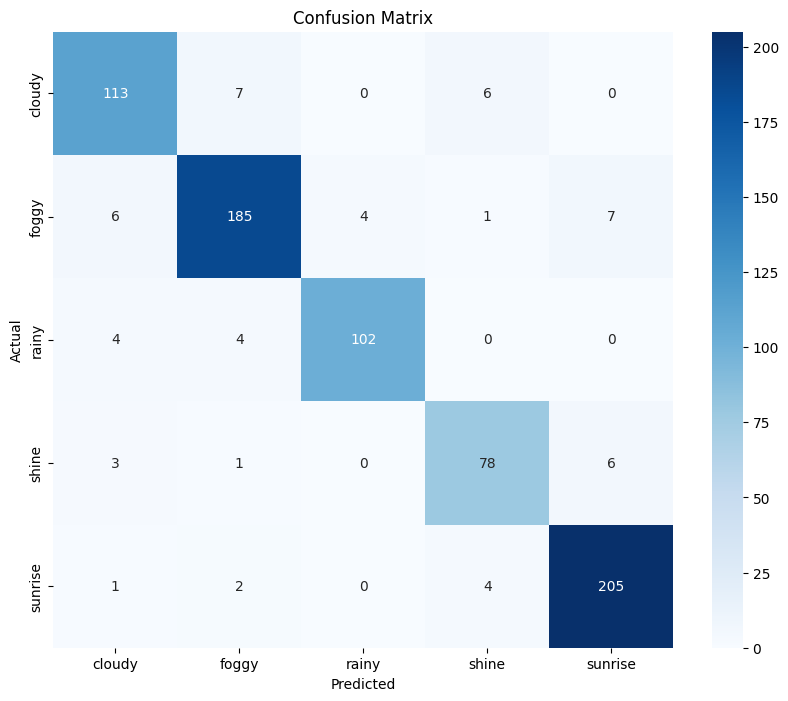

In [106]:
labels_list= list(sorted(set(sub['label']) | set(sub['predict'])))
total_predictions = len(sub)

correct_predictions = (sub['label'] == sub['predict']).sum()

accuracy = correct_predictions / total_predictions

from sklearn.metrics import classification_report
report = classification_report(sub['label'], sub['predict'], labels=labels_list)

print(f"Total predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(report)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(sub['label'], sub['predict'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_list) , yticklabels=list(labels_list))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Training Resnet50.tv2_in1k Model

In [17]:
all_tv2_preds = []
best_model_tv2_path = "/home/projekj/Deep learning/best_model/best_model_resnet_tv2.pth"

for i in range(config['num_folds']):
    dls = get_data(i)

    model = create_model(config['model_resnet_tv2'], num_classes=len(dls.vocab))
    augmentation_callback = get_augmentation_callback(config['augmentation_type'])
    learn = Learner(dls, model,
                    loss_func=weighted_loss,  # Use the custom loss function
                    metrics=accuracy,
                    cbs=[SaveModelCallback(monitor='valid_loss')])

    if config['mixed_precision']:
        learn = learn.to_fp16()

    # Move model to GPU(s)
    learn.model = learn.model.to('cuda')

    # Clear cache before training
    torch.cuda.empty_cache()
    
#     learn.fine_tune(config['fine_tune_epochs'])
    learn.fit_one_cycle(config['fit_one_cycle_epochs'], lr_max=config['learning_rate'])
#     learn.fit_one_cycle(config['fit_one_cycle_epochs'])
    learn.dls = get_data(i)
#     learn.fine_tune(config['fit_one_cycle_epochs'], cbs=EarlyStoppingCallback(monitor='valid_loss'))
    
    # Clear cache after training
    torch.cuda.empty_cache()

    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_tv2_preds.append(preds)
    torch.save(learn.model.state_dict(), best_model_tv2_path)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.573353,1.543680,0.393220,00:24
1,1.474169,1.269175,0.767797,00:04
2,1.125971,0.529687,0.854237,00:04
3,0.725685,0.381198,0.901695,00:04
4,0.465006,0.370251,0.903390,00:04
5,0.296996,0.341843,0.908475,00:04
6,0.186188,0.365008,0.922034,00:04
7,0.118334,0.377322,0.918644,00:04
8,0.083885,0.417084,0.922034,00:04
9,0.058866,0.407963,0.911864,00:04


Better model found at epoch 0 with valid_loss value: 1.54367995262146.
Better model found at epoch 1 with valid_loss value: 1.269175410270691.
Better model found at epoch 2 with valid_loss value: 0.5296868681907654.
Better model found at epoch 3 with valid_loss value: 0.3811984360218048.
Better model found at epoch 4 with valid_loss value: 0.3702511787414551.
Better model found at epoch 5 with valid_loss value: 0.34184348583221436.


epoch,train_loss,valid_loss,accuracy,time
0,1.605336,1.580556,0.292724,00:04
1,1.514303,1.347927,0.695431,00:04
2,1.178566,0.585617,0.844332,00:04
3,0.761642,0.408584,0.905245,00:04
4,0.471173,0.383949,0.901861,00:04
5,0.289870,0.371345,0.905245,00:04
6,0.188138,0.371434,0.910321,00:04
7,0.121719,0.404603,0.922166,00:04
8,0.081483,0.413189,0.912014,00:04
9,0.052880,0.412799,0.922166,00:04


Better model found at epoch 0 with valid_loss value: 1.58055579662323.
Better model found at epoch 1 with valid_loss value: 1.3479266166687012.
Better model found at epoch 2 with valid_loss value: 0.5856170058250427.
Better model found at epoch 3 with valid_loss value: 0.40858447551727295.
Better model found at epoch 4 with valid_loss value: 0.3839491307735443.
Better model found at epoch 5 with valid_loss value: 0.3713453412055969.


epoch,train_loss,valid_loss,accuracy,time
0,1.584595,1.544783,0.427119,00:04
1,1.483358,1.254756,0.759322,00:04
2,1.124290,0.560700,0.847458,00:04
3,0.713280,0.394619,0.886441,00:04
4,0.446425,0.368920,0.901695,00:04
5,0.285226,0.368986,0.891525,00:04
6,0.185800,0.363552,0.915254,00:04
7,0.116578,0.417227,0.910169,00:04
8,0.085489,0.430803,0.896610,00:04
9,0.069636,0.437118,0.905085,00:04


Better model found at epoch 0 with valid_loss value: 1.5447828769683838.
Better model found at epoch 1 with valid_loss value: 1.2547558546066284.
Better model found at epoch 2 with valid_loss value: 0.560699999332428.
Better model found at epoch 3 with valid_loss value: 0.394618958234787.
Better model found at epoch 4 with valid_loss value: 0.3689202666282654.
Better model found at epoch 6 with valid_loss value: 0.3635520935058594.


epoch,train_loss,valid_loss,accuracy,time
0,1.597761,1.559596,0.360406,00:04
1,1.502117,1.274445,0.693739,00:04
2,1.160404,0.552601,0.862944,00:04
3,0.748489,0.380655,0.900169,00:04
4,0.479437,0.325539,0.900169,00:04
5,0.301312,0.351187,0.901861,00:04
6,0.197369,0.348683,0.923858,00:04
7,0.122036,0.326421,0.923858,00:04
8,0.081341,0.365171,0.927242,00:04
9,0.055642,0.381291,0.920474,00:04


Better model found at epoch 0 with valid_loss value: 1.5595961809158325.
Better model found at epoch 1 with valid_loss value: 1.274444580078125.
Better model found at epoch 2 with valid_loss value: 0.5526012182235718.
Better model found at epoch 3 with valid_loss value: 0.38065528869628906.
Better model found at epoch 4 with valid_loss value: 0.32553941011428833.


epoch,train_loss,valid_loss,accuracy,time
0,1.580683,1.550774,0.400000,00:04
1,1.485420,1.288275,0.740678,00:04
2,1.141946,0.503579,0.857627,00:04
3,0.730573,0.354868,0.898305,00:04
4,0.463219,0.333325,0.906780,00:04
5,0.289983,0.330875,0.910169,00:04
6,0.187854,0.325392,0.913559,00:04
7,0.120577,0.366448,0.906780,00:04
8,0.081863,0.370161,0.920339,00:04
9,0.059574,0.397687,0.898305,00:04


Better model found at epoch 0 with valid_loss value: 1.5507744550704956.
Better model found at epoch 1 with valid_loss value: 1.2882752418518066.
Better model found at epoch 2 with valid_loss value: 0.5035790205001831.
Better model found at epoch 3 with valid_loss value: 0.35486799478530884.
Better model found at epoch 4 with valid_loss value: 0.3333253860473633.
Better model found at epoch 5 with valid_loss value: 0.33087483048439026.
Better model found at epoch 6 with valid_loss value: 0.3253919184207916.


In [18]:
sub = pd.read_csv(config['test_csv_path'])
preds = np.mean(np.stack(all_tv2_preds), axis=0)
preds = torch.from_numpy(preds)
idxs = preds.argmax(dim=1)
confidences, _ = torch.max(preds, dim=1)
vocab = np.array(dls.vocab)

sub['predict'] = vocab[idxs]
sub

,image_path,label,predict
0,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise45.jpg,sunrise,sunrise
1,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise1_337.jpg,sunrise,sunrise
2,/home/projekj/Deep learning/dataset/dataset/sunrise/sunrise0_25.jpg,sunrise,sunrise
3,/home/projekj/Deep learning/dataset/dataset/shine/shine43.jpg,shine,shine
4,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_0_187.jpg,foggy,foggy
...,...,...,...
734,/home/projekj/Deep learning/dataset/dataset/cloudy/cloudy1_225.jpg,cloudy,foggy
735,/home/projekj/Deep learning/dataset/dataset/shine/shine49.jpg,shine,shine
736,/home/projekj/Deep learning/dataset/dataset/rainy/rain25.jpg,rainy,rainy
737,/home/projekj/Deep learning/dataset/dataset/foggy/foggy_1_292.jpg,foggy,foggy


# Resnet50.tv2_in1k Model Result

Total predictions: 739
Correct predictions: 704
Accuracy: 95.26%

Classification Report:
              precision    recall  f1-score   support

      cloudy       0.97      0.93      0.95       126
       foggy       0.95      0.96      0.95       203
       rainy       0.98      0.98      0.98       110
       shine       0.91      0.90      0.90        88
     sunrise       0.95      0.97      0.96       212

    accuracy                           0.95       739
   macro avg       0.95      0.95      0.95       739
weighted avg       0.95      0.95      0.95       739



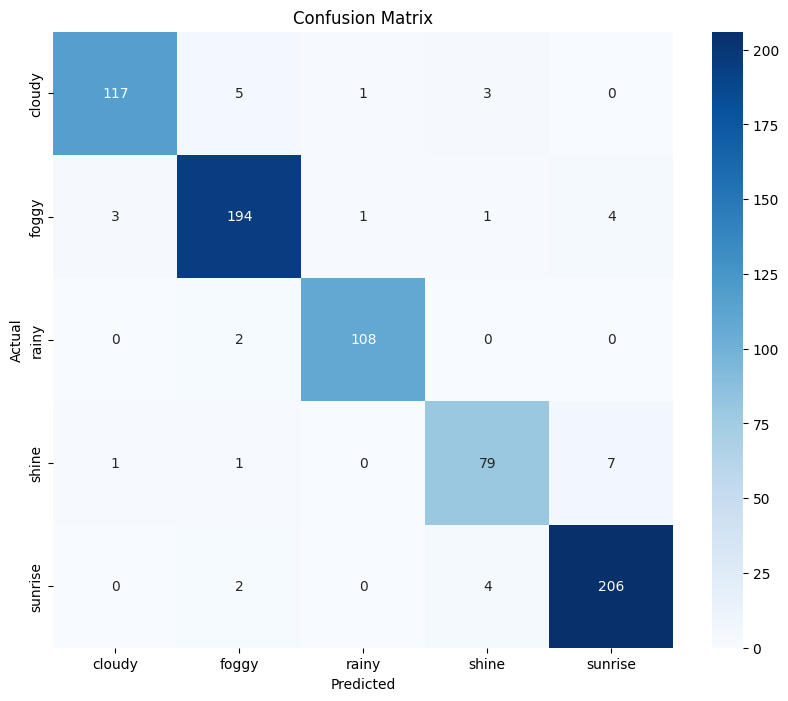

In [19]:
labels_list= list(sorted(set(sub['label']) | set(sub['predict'])))
total_predictions = len(sub)

correct_predictions = (sub['label'] == sub['predict']).sum()

accuracy = correct_predictions / total_predictions

from sklearn.metrics import classification_report
report = classification_report(sub['label'], sub['predict'], labels=labels_list)

print(f"Total predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(report)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(sub['label'], sub['predict'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels_list) , yticklabels=list(labels_list))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from torchvision import transforms
import time
def create_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def predict(image_path, model_path, class_names):
    model = create_model(num_classes=len(class_names))
    
    state_dict = torch.load(model_path)
    
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    start_time = time.time()
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_index = probabilities.argmax().item()
        predicted_class = class_names[predicted_class_index]
    end_time = time.time()
    inference_time = end_time - start_time 
    print(f"Inference time: {inference_time:.6f} seconds")  
    return predicted_class, probabilities[0].tolist(), img

def show_image(image):
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

    
def display_probabilities(class_names, probabilities):

    sorted_probs = sorted(zip(class_names, probabilities), key=lambda x: x[1], reverse=True)
    
    print("Class Probabilities:")
    print("-------------------")
    for class_name, prob in sorted_probs:
        print(f"{class_name:<15} : {prob:.4f} ({prob*100:.2f}%)")

def predict_folder(folder_path, model_path, class_names):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        predicted_class, probabilities, img = predict(image_path, model_path, class_names)
        
        show_image(img)
        
        print(f"Predicted class : {predicted_class}")
        display_probabilities(class_names, probabilities)
        print("-" * 50)

# DEMO Resnet50.a1_in1k Model

Inference time: 0.060783 seconds


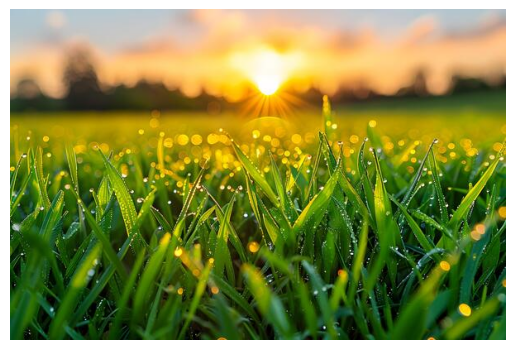

Predicted class : sunrise
Class Probabilities:
-------------------
sunrise         : 0.8906 (89.06%)
shine           : 0.0975 (9.75%)
foggy           : 0.0081 (0.81%)
rainy           : 0.0021 (0.21%)
cloudy          : 0.0018 (0.18%)
--------------------------------------------------
Inference time: 0.078650 seconds


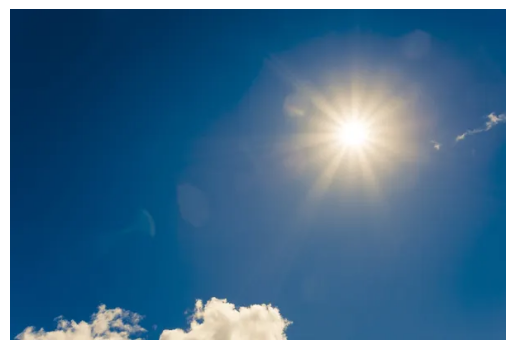

Predicted class : shine
Class Probabilities:
-------------------
shine           : 0.9977 (99.77%)
foggy           : 0.0015 (0.15%)
sunrise         : 0.0006 (0.06%)
cloudy          : 0.0002 (0.02%)
rainy           : 0.0000 (0.00%)
--------------------------------------------------
Inference time: 0.060701 seconds


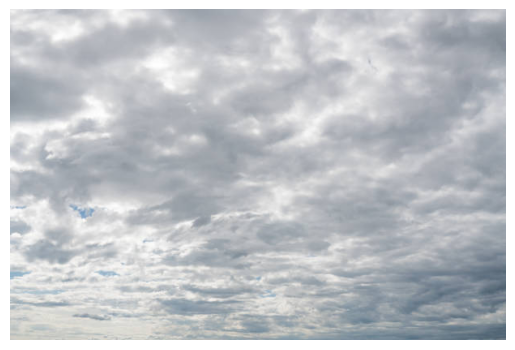

Predicted class : cloudy
Class Probabilities:
-------------------
cloudy          : 0.9883 (98.83%)
shine           : 0.0068 (0.68%)
rainy           : 0.0024 (0.24%)
foggy           : 0.0015 (0.15%)
sunrise         : 0.0010 (0.10%)
--------------------------------------------------
Inference time: 0.074945 seconds


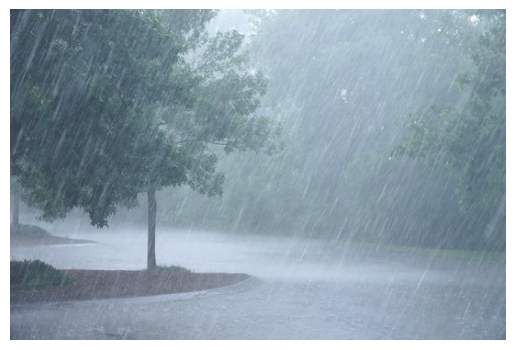

Predicted class : rainy
Class Probabilities:
-------------------
rainy           : 0.9218 (92.18%)
foggy           : 0.0368 (3.68%)
cloudy          : 0.0160 (1.60%)
shine           : 0.0150 (1.50%)
sunrise         : 0.0105 (1.05%)
--------------------------------------------------
Inference time: 0.057066 seconds


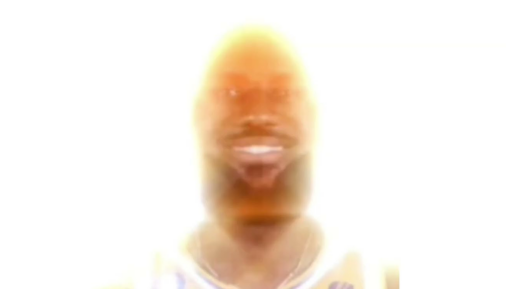

Predicted class : shine
Class Probabilities:
-------------------
shine           : 0.5455 (54.55%)
foggy           : 0.1557 (15.57%)
sunrise         : 0.1426 (14.26%)
cloudy          : 0.0951 (9.51%)
rainy           : 0.0611 (6.11%)
--------------------------------------------------
Inference time: 0.077523 seconds


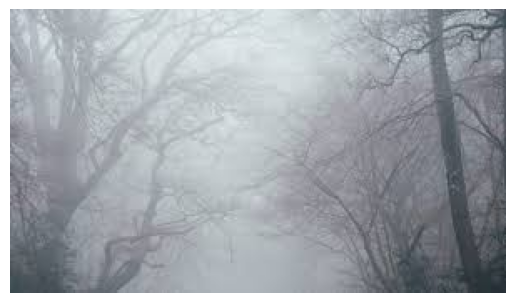

Predicted class : foggy
Class Probabilities:
-------------------
foggy           : 0.9217 (92.17%)
cloudy          : 0.0405 (4.05%)
rainy           : 0.0200 (2.00%)
shine           : 0.0109 (1.09%)
sunrise         : 0.0069 (0.69%)
--------------------------------------------------


In [25]:
folder_path = '/home/projekj/Deep learning/demo/real'
model_path = '/home/projekj/Deep learning/best_model/best_model_resnet_a1.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predict_folder(folder_path, model_path, labels_list)

# DEMO Resnet50.tv2_in1k Model

Inference time: 0.073927 seconds


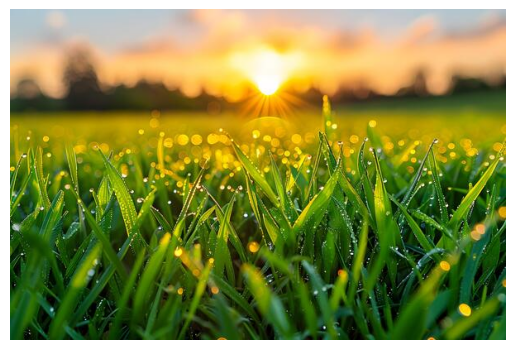

Predicted class : sunrise
Class Probabilities:
-------------------
sunrise         : 0.7460 (74.60%)
shine           : 0.2277 (22.77%)
rainy           : 0.0150 (1.50%)
foggy           : 0.0076 (0.76%)
cloudy          : 0.0037 (0.37%)
--------------------------------------------------
Inference time: 0.064201 seconds


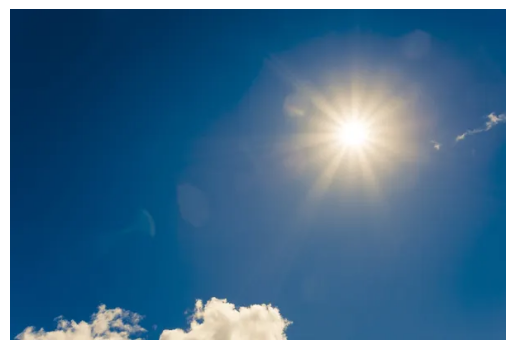

Predicted class : shine
Class Probabilities:
-------------------
shine           : 0.9995 (99.95%)
cloudy          : 0.0002 (0.02%)
sunrise         : 0.0002 (0.02%)
foggy           : 0.0001 (0.01%)
rainy           : 0.0001 (0.01%)
--------------------------------------------------
Inference time: 0.071672 seconds


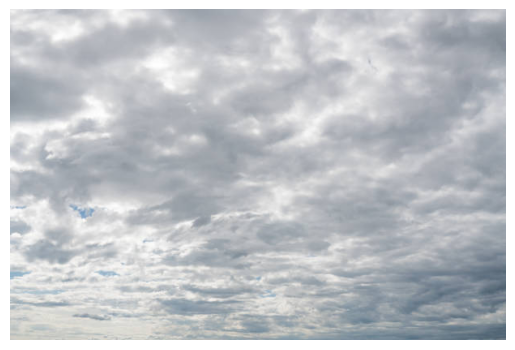

Predicted class : cloudy
Class Probabilities:
-------------------
cloudy          : 0.9789 (97.89%)
shine           : 0.0108 (1.08%)
rainy           : 0.0046 (0.46%)
foggy           : 0.0039 (0.39%)
sunrise         : 0.0017 (0.17%)
--------------------------------------------------
Inference time: 0.066340 seconds


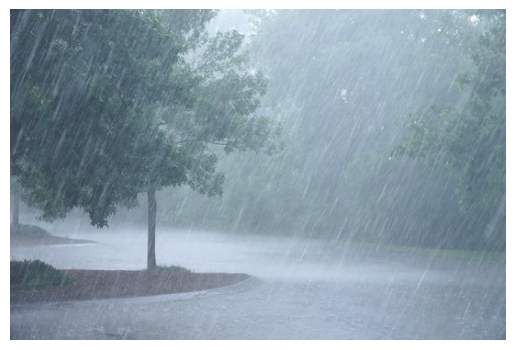

Predicted class : rainy
Class Probabilities:
-------------------
rainy           : 0.9998 (99.98%)
foggy           : 0.0001 (0.01%)
shine           : 0.0000 (0.00%)
cloudy          : 0.0000 (0.00%)
sunrise         : 0.0000 (0.00%)
--------------------------------------------------
Inference time: 0.064781 seconds


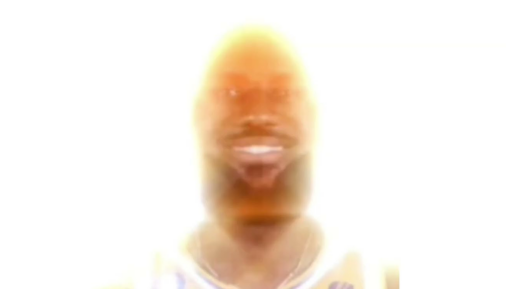

Predicted class : shine
Class Probabilities:
-------------------
shine           : 0.4007 (40.07%)
foggy           : 0.3263 (32.63%)
sunrise         : 0.1497 (14.97%)
cloudy          : 0.0645 (6.45%)
rainy           : 0.0588 (5.88%)
--------------------------------------------------
Inference time: 0.065827 seconds


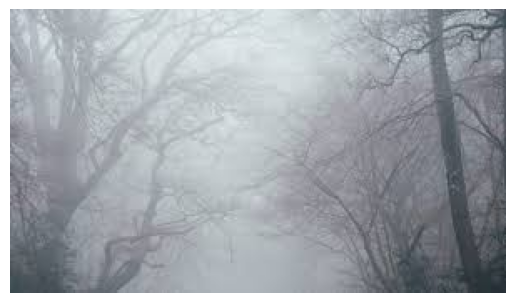

Predicted class : foggy
Class Probabilities:
-------------------
foggy           : 0.8807 (88.07%)
cloudy          : 0.0885 (8.85%)
shine           : 0.0141 (1.41%)
rainy           : 0.0122 (1.22%)
sunrise         : 0.0045 (0.45%)
--------------------------------------------------


In [26]:
folder_path = '/home/projekj/Deep learning/demo/real'
model_path = '/home/projekj/Deep learning/best_model/best_model_resnet_tv2.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predict_folder(folder_path, model_path, labels_list)